In [8]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd

In [9]:
# Load environment variables from a .env file
load_dotenv()

# Use env vars for connection
db_user = os.getenv("DB_USER", "postgres")
db_password = os.getenv("DB_PASSWORD", "")
db_host = os.getenv("DB_HOST", "localhost")
db_port = os.getenv("DB_PORT", "5432")
db_name = os.getenv("DB_NAME", "portfolio_db")

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Example query
query = """
SELECT *
FROM target_ecommerce.orders
LIMIT 100;
"""

df = pd.read_sql_query(query, engine)
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.patheffects as path_effects

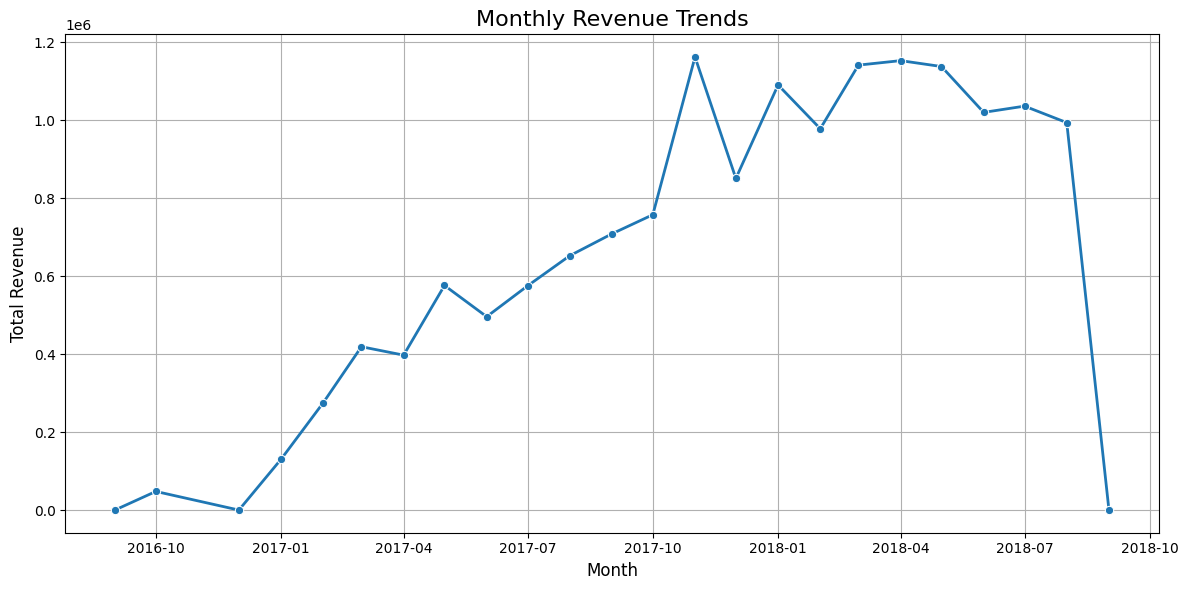

In [11]:
query = """
SELECT
    TO_CHAR(o.order_purchase_timestamp, 'YYYY-MM') AS order_year_month,
    SUM(COALESCE(p.payment_value, 0)) AS total_revenue
FROM
    target_ecommerce.orders AS o
INNER JOIN
    target_ecommerce.payments AS p ON o.order_id = p.order_id
WHERE
    o.order_status IN ('shipped', 'delivered')
GROUP BY
    order_year_month
ORDER BY
    order_year_month;
"""

df = pd.read_sql_query(query, engine)

df['order_year_month'] = pd.to_datetime(df['order_year_month'], format='%Y-%m')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='order_year_month', y='total_revenue', marker='o', linewidth=2)

plt.title('Monthly Revenue Trends', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.savefig('../visualisations/01_monthly_revenue_trend.png', dpi=300)
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_36436\3616157407.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='product_category', x='total_revenue', palette='viridis')


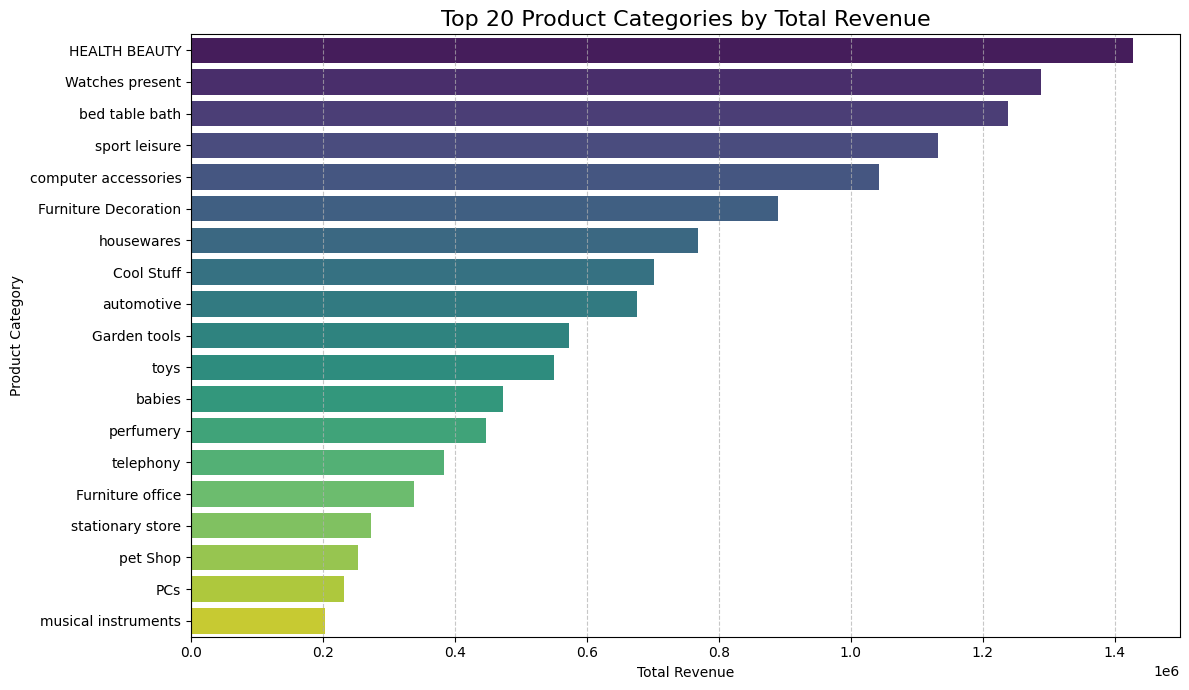

In [12]:
query = """
SELECT
    p.product_category,
    SUM(COALESCE(oi.price, 0) + COALESCE(oi.freight_value, 0)) AS total_revenue
FROM
    target_ecommerce.order_items AS oi
INNER JOIN
    target_ecommerce.orders AS o ON oi.order_id = o.order_id
INNER JOIN
    target_ecommerce.products AS p ON oi.product_id = p.product_id
WHERE
    o.order_status IN ('shipped', 'delivered')
GROUP BY
    p.product_category
ORDER BY
    total_revenue DESC
LIMIT 20;
"""

df = pd.read_sql_query(query, engine)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(data=df, y='product_category', x='total_revenue', palette='viridis')

plt.title('Top 20 Product Categories by Total Revenue', fontsize=16)
plt.xlabel('Total Revenue')
plt.ylabel('Product Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('../visualisations/01_revenue_by_top20_product_categories.png', dpi=300)

plt.show()

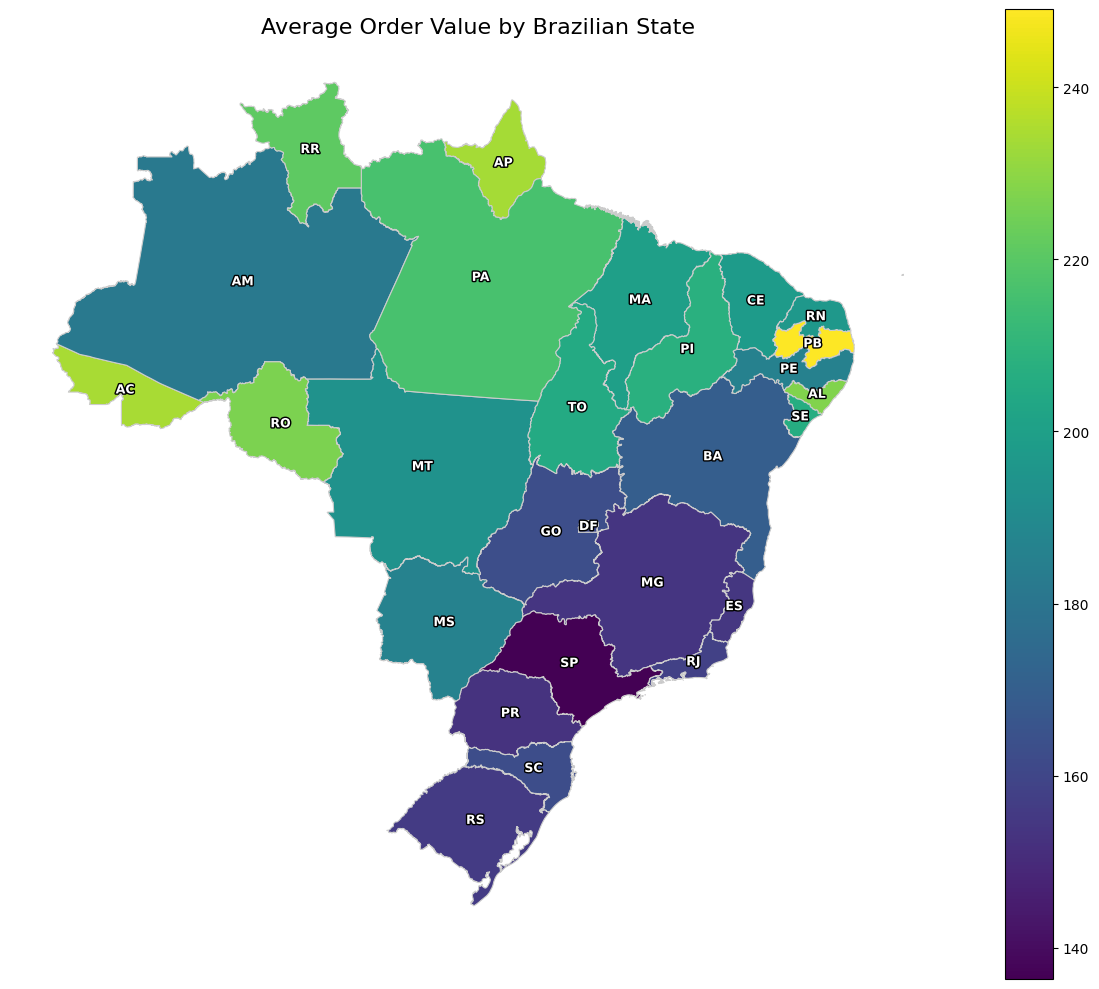

In [13]:
query = """
SELECT
    c.customer_state,
    AVG(COALESCE(p.payment_value, 0)) AS average_order_value
FROM
    target_ecommerce.payments AS p
INNER JOIN
    target_ecommerce.orders AS o ON p.order_id = o.order_id
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
WHERE
    o.order_status IN ('shipped', 'delivered')
GROUP BY
    c.customer_state
ORDER BY
    average_order_value DESC;
"""

df = pd.read_sql_query(query, engine)

# Load Brazil states geometry data
geo_path = '..\\data\\brazil-states.geojson'  # fixed slashes for Windows
gdf = gpd.read_file(geo_path)

# Rename df column to match shapefile state abbreviation column
df.rename(columns={'customer_state': 'sigla'}, inplace=True)

# Merge spatial data with your revenue data
merged = gdf.merge(df, on='sigla')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='average_order_value',
            cmap='viridis',
            linewidth=0.8,
            edgecolor='0.8',
            legend=True,
            ax=ax)

# Add labels with white text and black outline for readability
for idx, row in merged.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['sigla'],
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=9,
            fontweight='bold',
            color='white',
            path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])

ax.set_title('Average Order Value by Brazilian State', fontsize=16)
ax.axis('off')

plt.tight_layout()

plt.savefig('../visualisations/01_average_order_value.png', dpi=300)

plt.show()


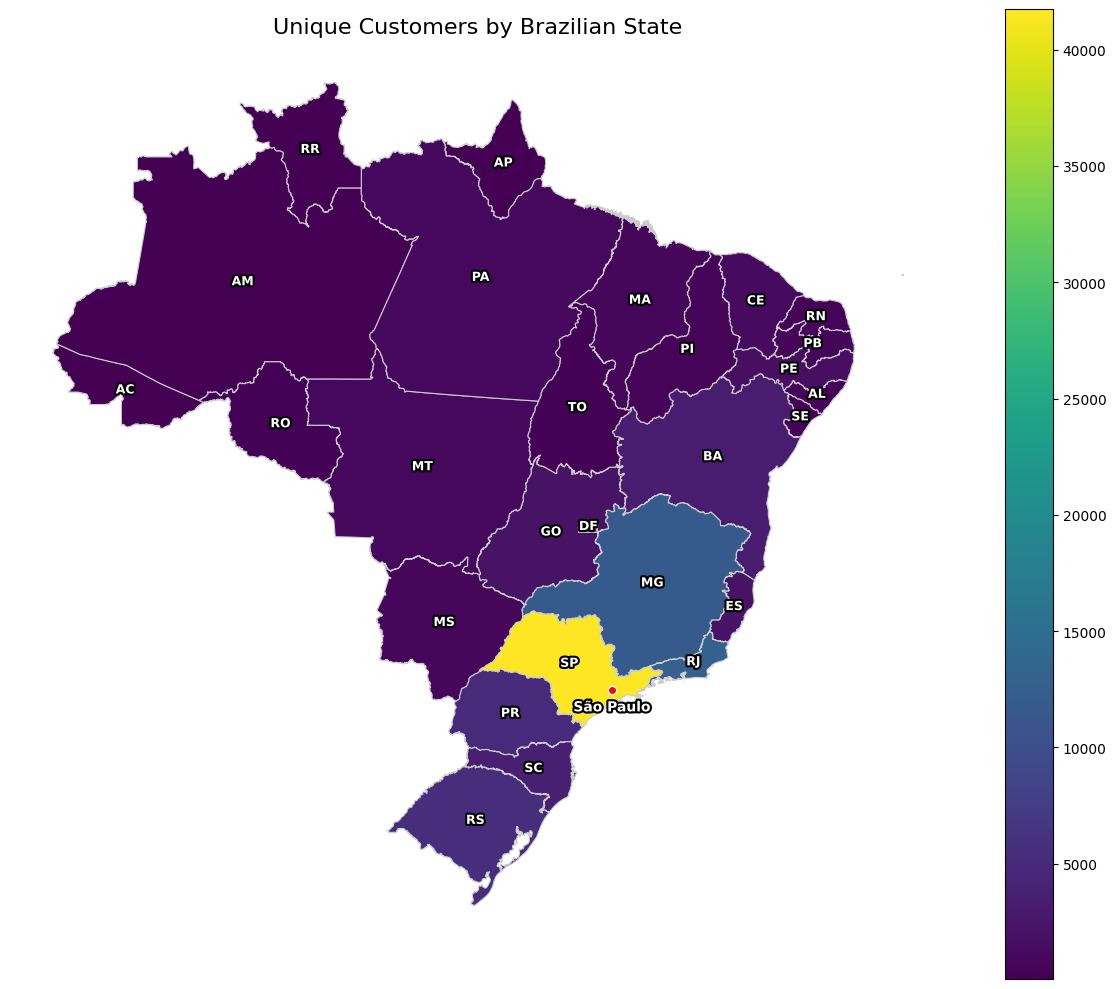

In [17]:
query = """
SELECT
    c.customer_state,
    COUNT(DISTINCT c.customer_id) AS unique_customers_count
FROM
    target_ecommerce.orders AS o
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
GROUP BY
    c.customer_state
ORDER BY
    unique_customers_count DESC;
"""

df = pd.read_sql_query(query, engine)

# Load Brazil states geometry
geo_path = '..\\data\\brazil-states.geojson'
gdf = gpd.read_file(geo_path)

# Match column for merging
df.rename(columns={'customer_state': 'sigla'}, inplace=True)

# Merge geographic and customer data
merged = gdf.merge(df, on='sigla')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='unique_customers_count',
            cmap='viridis',
            linewidth=0.8,
            edgecolor='0.8',
            legend=True,
            ax=ax)

# Add state labels with outlines for visibility
for idx, row in merged.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['sigla'],
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=9,
            fontweight='bold',
            color='white',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])

# Add a custom marker and label for São Paulo city
sp_lon, sp_lat = -46.6333, -23.5505

# Plot marker
ax.plot(sp_lon, sp_lat, marker='o', markersize=6, color='red', markeredgecolor='white', zorder=5)

# Add label
ax.text(sp_lon, sp_lat - 0.8, 'São Paulo',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=10,
        fontweight='bold',
        color='white',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='black')],
        zorder=6)


ax.set_title('Unique Customers by Brazilian State', fontsize=16)
ax.axis('off')

plt.tight_layout()

plt.savefig('../visualisations/02_unique_customers_by_state.png', dpi=300)

plt.show()

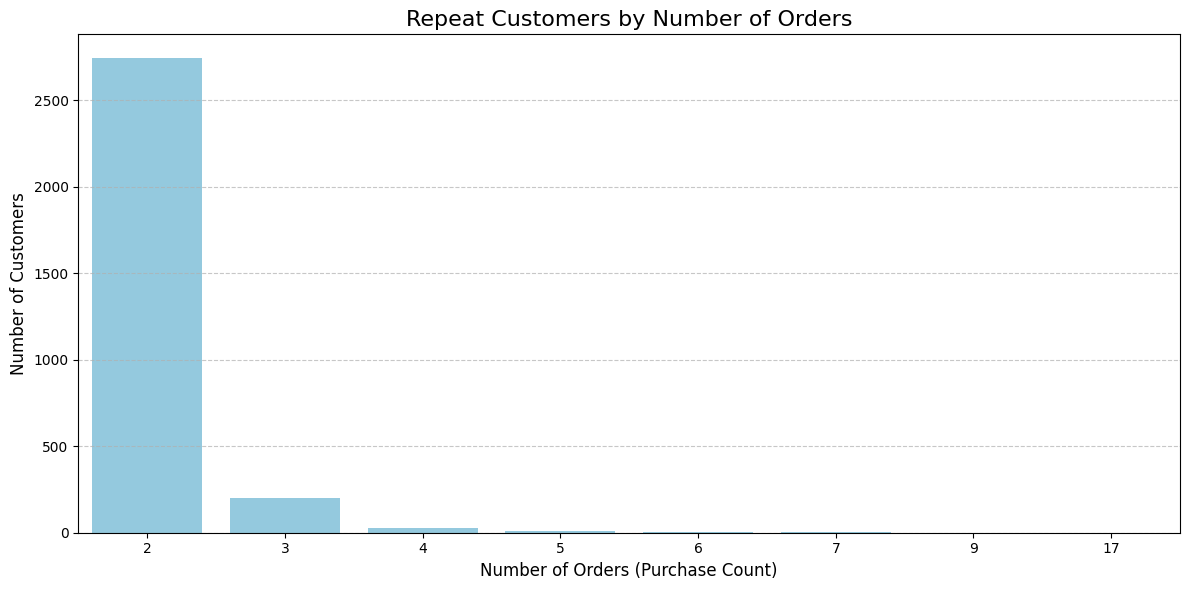

In [22]:
# Query: Frequency distribution of repeat customers
query = """
SELECT
    num_orders AS purchase_count,
    COUNT(*) AS customer_count
FROM (
    SELECT
        c.customer_unique_id,
        COUNT(DISTINCT o.order_id) AS num_orders
    FROM
        target_ecommerce.orders AS o
    LEFT JOIN
        target_ecommerce.customers AS c ON o.customer_id = c.customer_id
    GROUP BY
        c.customer_unique_id
) AS customer_orders
GROUP BY
    num_orders
ORDER BY
    num_orders;
"""

# Load data
df = pd.read_sql_query(query, engine)

# Filter out one-time customers
df = df[df['purchase_count'] > 1]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='purchase_count', y='customer_count', color='skyblue')

plt.title('Repeat Customers by Number of Orders', fontsize=16)
plt.xlabel('Number of Orders (Purchase Count)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('../visualisations/02_repeat_customers_by_order_count.png', dpi=300)

plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_36436\2386018347.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='segment', y='avg_orders', ax=axes[0], palette='viridis')
C:\Users\james\AppData\Local\Temp\ipykernel_36436\2386018347.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='segment', y='avg_spent', ax=axes[1], palette='viridis')


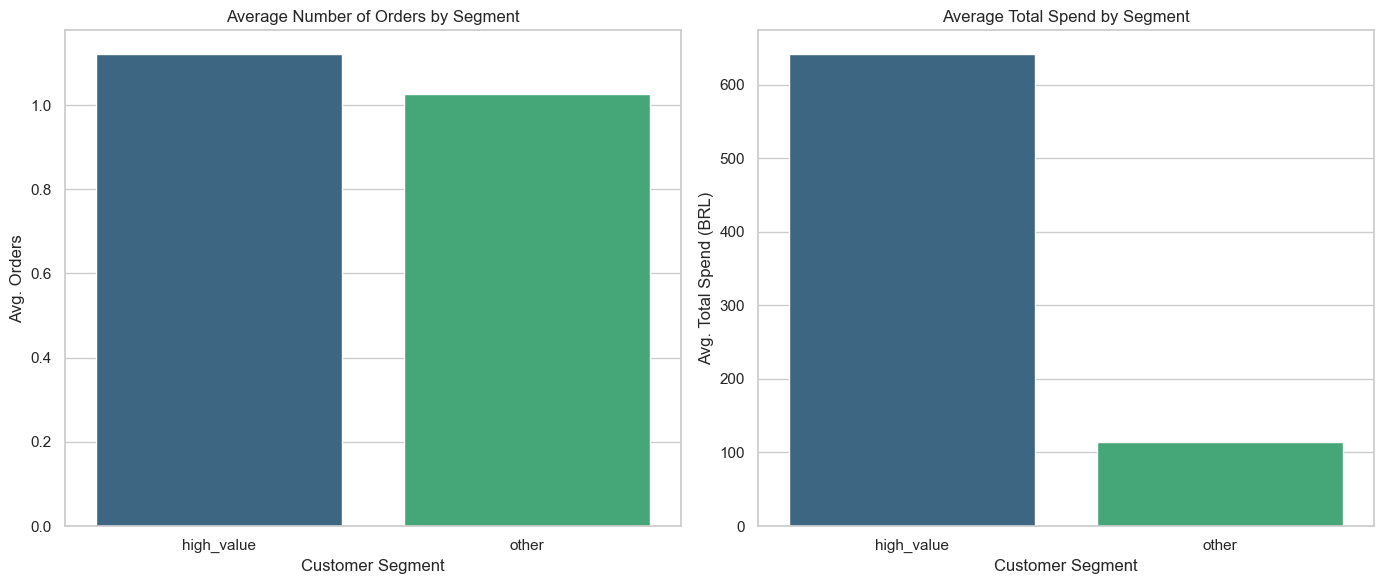

In [26]:
query = """
WITH customer_spend AS (
    SELECT
        c.customer_unique_id,
        SUM(p.payment_value) AS total_spent,
        COUNT(DISTINCT o.order_id) AS num_orders
    FROM
        target_ecommerce.orders AS o
    INNER JOIN
        target_ecommerce.payments AS p ON o.order_id = p.order_id
    LEFT JOIN
        target_ecommerce.customers AS c ON o.customer_id = c.customer_id
    GROUP BY
        c.customer_unique_id
),
spend_threshold AS (
    SELECT
        PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY total_spent) AS threshold
    FROM
        customer_spend
),
segmented_customers AS (
    SELECT
        cs.*,
        CASE
            WHEN cs.total_spent >= st.threshold THEN 'high_value'
            ELSE 'other'
        END AS segment
    FROM
        customer_spend AS cs
    CROSS JOIN
        spend_threshold AS st
)
SELECT
    segment,
    COUNT(*) AS customer_count,
    AVG(num_orders) AS avg_orders,
    AVG(total_spent) AS avg_spent
FROM
    segmented_customers
GROUP BY
    segment;
"""

df = pd.read_sql_query(query, engine)

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart 1: Average Orders
sns.barplot(data=df, x='segment', y='avg_orders', ax=axes[0], palette='viridis')
axes[0].set_title('Average Number of Orders by Segment')
axes[0].set_ylabel('Avg. Orders')
axes[0].set_xlabel('Customer Segment')

# Bar chart 2: Average Spend
sns.barplot(data=df, x='segment', y='avg_spent', ax=axes[1], palette='viridis')
axes[1].set_title('Average Total Spend by Segment')
axes[1].set_ylabel('Avg. Total Spend (BRL)')
axes[1].set_xlabel('Customer Segment')

plt.tight_layout()

plt.savefig('../visualisations/02_order_count_and_total_spend.png', dpi=300)

plt.show()
